# Data extraction 
Parse the color from the color scheme json (hexadecimal to octal rgb format)

In [1]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


#convert # FFFFFA to  255,255,250
def huv2num(huv):
#     print(huv)
    try:
        huv = huv.replace('##','#')
        r = int('0x'+ huv[1:3],16)
        g = int('0x'+ huv[3:5],16)
        b = int('0x'+ huv[5:],16)
        return (r,g,b)
    except:
        return None


def parseJson(jsonPath,colors):
    #color_sche = []
    color_set = []
    with open(jsonPath,'r',encoding = 'utf-8') as load_color:
        load_dict = json.load(load_color)
        for key, value in load_dict.items():
            try:

                for val in value:
                    val = huv2num(val)
                    color_set.append(val)   
                color = [huv2num(val) for val in value if huv2num(val)]
                if len(color) == 5:
                    colors.append(tuple(color))
            except OSError:
                pass

In [2]:
style  =  os.listdir('./palettes/')
colors = []
for name in style :
    jsonPath  =  os.path.join('./palettes/', name)
    if jsonPath.endswith('json'):
        parseJson(jsonPath,colors)
        
        
        dir_A = os.path.join('./peisenet_palettes',name.split('.')[0])
        if os.path.exists(dir_A):
            print("Directory is exist!")
        else:    
            os.makedirs(dir_A)

            for  i , color  in  enumerate (colors):
                im=Image.new('RGB',(1000,1),(0,0,0)) #바탕생성 Image.new(mode,size,color)
                draw=ImageDraw.Draw(im)
                batch = int(1000 / 5)
                for j, c in enumerate(color):
                    if  j != 4 :
                        draw.rectangle((j*batch,0,(j+1)*batch,1),fill=c)
                    else:
                        draw.rectangle((j*batch,0,1000,1),fill=c)
                    im.save(dir_A + f'/{i}.png')

Directory is exist!


# Data visualization

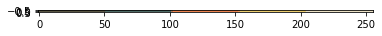

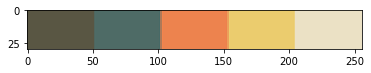

(1000, 1)

In [3]:
img=Image.open('./peisenet_palettes/full_colorlover/100.png')
# img = Image.fromarray(img)

new=img.resize(size=(256,1))
new1 = new.resize(size=(256,30))

plt.imshow(np.array(new))
plt.show()
plt.imshow(np.array(new1))
plt.show()

img.size

# Models built 
Pix2pix's network structure is used for training. Some differences are in the input size. I use 256 1 instead of 256 256 in the image . The input becomes smaller, so I increased the number of channels. By default, the first layer uses 128. Channels.

In [4]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
import keras.backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model

import random
import tensorflow as tf

from IPython.display import SVG
from IPython.display import clear_output

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/pj2_sam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/pj2_sam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/pj2_sam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anac

In [5]:
print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4


In [6]:
# Weights initializations
# bias are initailized as 0

# def __conv_init(a):
#     print("conv_init", a)
#     k = RandomNormal(0, 0.02)(a) # for convolution kernel
#     k.conv_weight = True    
#     return k

In [7]:
# Basic discriminator
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    

    input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=-1)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=(1,4), strides=(1,2), padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=(1,4), strides=(1,2), padding="same", 
                   use_bias=False, name = f'pyramid.{layer}'
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(out_feat, kernel_size=(1,4),  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(1, kernel_size=(1,4), name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [8]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=128, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=(1,4), strides=(1,2), use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = f'conv_{s}') (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=-1)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=(1,4), strides=(1,2), use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = f'convt.{s}')(x)        
        x = Cropping2D(cropping=((0,0),(1,1)))(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None

    _ = inputs = Input(shape=(1, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [9]:
nc_in = 3
nc_out = 3
ndf = 128
imageSize = 256
ngf = 128

netD = BASIC_D(nc_in, nc_out, ndf)
netG = UNET_G(imageSize, nc_in, nc_out, ngf)

netD.summary()
netG.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 6 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
_______________________________________________________________________________________

In [10]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [11]:
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))

In [12]:
lrD = 2e-4
lrG = 2e-4


loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B], [loss_D/2], training_updates)

loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

# Data reading function, generator for training 
During the generation process, the original color scheme is used as the label. I will also randomly paint a few areas of the five color areas as input for training.

In [13]:
def load_data(dataPath):
    dataAB = []
    for root,dirs,files in os.walk(dataPath):
        for f in files:
            if f.endswith('png'):
                dataAB.append(os.path.join(root,f))
    random.shuffle(dataAB)
    
    return dataAB[:int(len(dataAB)*0.85)], dataAB[int(len(dataAB)*0.85):]


def read_image(img_name):
    im = Image.open(img_name)
    im_fake = im.copy()
    draw_fake = ImageDraw.Draw(im_fake)
    batch = int(im.size[0] / 5)
    nb = random.randint(1,4)
    index = random.sample([k for k in range(5)],nb)

    for j in range(5):
        if j in index:
            if j != 4:
                draw_fake.rectangle((j*batch,0,(j+1)*batch,1),fill=(0,0,0))
            else:
                draw_fake.rectangle((j*batch,0,im.size[0],1),fill=(0,0,0))

    imgB = im
    imgA = im_fake
    
    outA = np.array(imgA.resize((256,1))) / 255 * 2 - 1
    outB = np.array(imgB.resize((256,1))) / 255 * 2 - 1
    return outA, outB

In [14]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB) * 10
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            random.shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[int(j % len(dataAB))])
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB  

In [15]:
def showX(X, epoch=0, rows=3, savefig=True):
    plt.figure(figsize=(10,5))
    X = np.concatenate(X,1)
    for i in range(rows):
        plt.subplot(2,3,i+1)
        plt.imshow(np.array(Image.fromarray(((X[i]+1)/2*255).clip(0,255).astype('uint8')).resize((512,100))))
    
    if savefig:
        if not os.path.exists('results/'):
            os.makedirs('results/')
        plt.savefig(f'results/epoch_{epoch}.png')
    
    plt.show()

# Visualization of training 

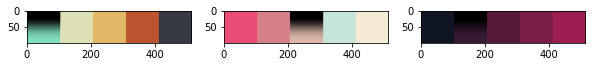

In [16]:
trainAB, valAB = load_data('./peisenet_palettes/full_colorlover/')

train_batch = minibatch(trainAB, 6)
_, trainA, trainB = next(train_batch)
showX([trainA,trainB], savefig=False)
_,a,b = train_batch.send(6)

del train_batch, trainA, trainB

# Training 
During the training process, if the training is performed in the order of a generator and a discriminator, the result will be very poor, and the generation result is very bad, so the actual training one iteration took 3 times to generate a discriminant.

In [17]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

In [18]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

batchSize = 1
niter = 3
display_iters = 2000

gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

train_batch = minibatch(trainAB, batchSize)
val_batch = minibatch(valAB, 6)
current_iter = 0

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum += errD
    
    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    
    for i in range(3):        
        _, trainA1, trainB1 = next(train_batch)
        errG, errL1 = netG_train([trainA1, trainB1])
        errG_sum += errG
        errL1_sum += errL1
    
    gen_iterations += 1
    if gen_iterations % display_iters == 0:
        if gen_iterations % (5*display_iters) == 0:
            clear_output()
        print(f'[{epoch}/{niter}][{gen_iterations}] Loss_D: {errD_sum/display_iters} ' + 
              f'Loss_G: {errG_sum/(display_iters*4)} loss_L1: {errL1_sum/(display_iters*4)}')
        
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
        
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
        
    if epoch > current_iter:
        current_iter += 1
        
        if not os.path.exists('weights/100L1_128channel_4gen/generator/'):
            os.makedirs('weights/100L1_128channel_4gen/generator/')
        if not os.path.exists('weights/100L1_128channel_4gen/discriminator/'):
            os.makedirs('weights/100L1_128channel_4gen/discriminator/')
        
        netG.save(f'./weights/100L1_128channel_4gen/generator/epoch_{epoch}.hdf5')
        netD.save(f'./weights/100L1_128channel_4gen/discriminator/epoch_{epoch}.hdf5')

# Test

In [19]:
# Here I trained three models based on different parameters, used here as appropriate
# generator = load_model('weights/GAN/100L1_128channel_peisenet/generator/epoch_2.hdf5')
# generator1 = load_model('weights/GAN/100L1_128channel_4gen/generator/epoch_10.hdf5')
# generator2 = load_model('weights/GAN/1000L1_256channel/generator/epoch_10.hdf5')

generator = load_model('weights/100L1_128channel_4gen/generator/epoch_1.hdf5')
generator1 = load_model('weights/100L1_128channel_4gen/generator/epoch_2.hdf5')
generator2 = load_model('weights/100L1_128channel_4gen/generator/epoch_3.hdf5')

/home/ubuntu/anaconda3/envs/pj2_sam/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [20]:
for layer in generator.layers:
    layer.trainable = False

Processing 0 ... 


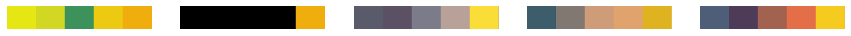

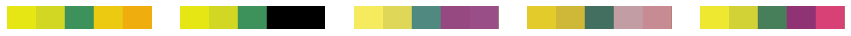

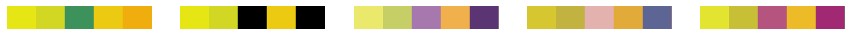

Processing 1 ... 


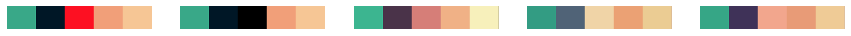

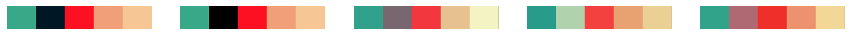

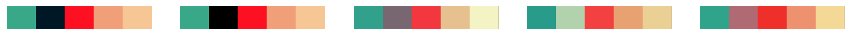

Processing 2 ... 


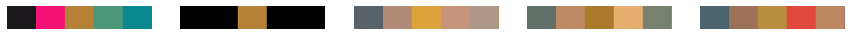

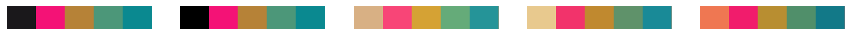

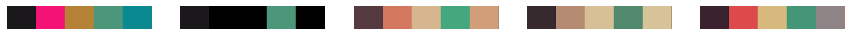

Processing 3 ... 


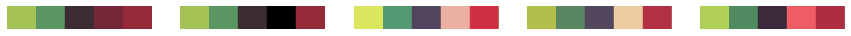

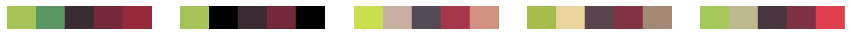

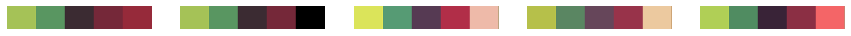

Processing 4 ... 


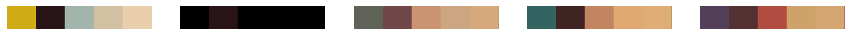

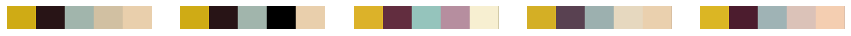

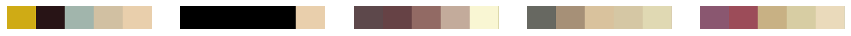

Processing 5 ... 


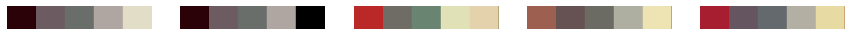

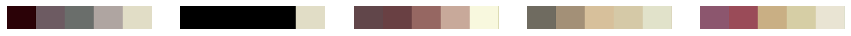

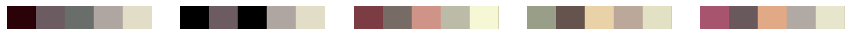

Processing 6 ... 


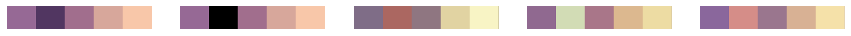

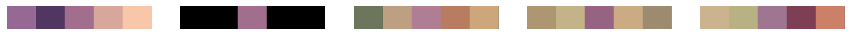

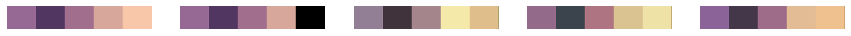

Processing 7 ... 


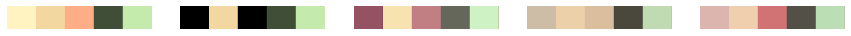

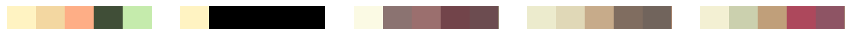

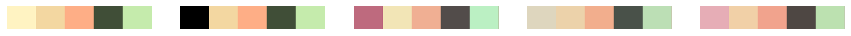

Processing 8 ... 


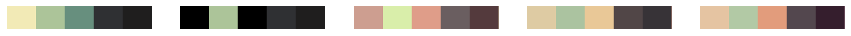

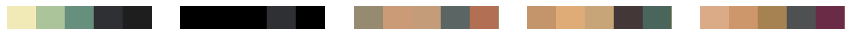

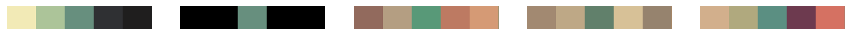

Processing 9 ... 


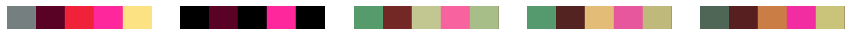

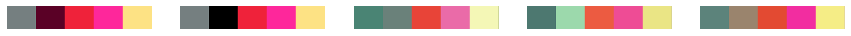

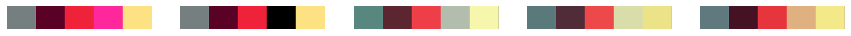

In [21]:
random.shuffle(colors)
# color = colors[100]

for i,color in enumerate(colors[:10]):
    print(f'Processing {i} ... ')

    # color = [(212,123,80) for _ in range(8)]
    batch = int(256 / 5)
    for _ in range(3):
        img = Image.new("RGB",(256,1),(0,0,0))
        im = np.array(img)
        im_fake = np.array(img)
        nb = random.randint(1,4)
        index = random.sample([k for k in range(5)],nb)
        for j, c in enumerate(color):
            if j not in index:
                if j == len(color)-1:
                    im_fake[:,j*batch:,:] = c
                else:
                    im_fake[:,j*batch:(j+1)*batch,:] = c

            if j == len(color)-1:
                im[:,j*batch:,:] = c
            else:
                im[:,j*batch:(j+1)*batch,:] = c


        plt.figure(figsize=(15,15))

        plt.subplot(1,5,1)
        plt.imshow(np.array(Image.fromarray(im).resize((512,80))))
        plt.axis('off')

        plt.subplot(1,5,2)
        plt.imshow(np.array(Image.fromarray(im_fake).resize((512,80))))
        plt.axis('off')

        result = generator.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        result1 = generator1.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        result2 = generator2.predict(np.expand_dims(im_fake / 255 * 2 - 1,0))[0]
        
        for i in range(5):
            result[:,i*batch:(i+1)*batch,:] = np.mean(result[:,i*batch:(i+1)*batch,:],1)[0]
            result1[:,i*batch:(i+1)*batch,:] = np.mean(result1[:,i*batch:(i+1)*batch,:],1)[0]
            result2[:,i*batch:(i+1)*batch,:] = np.mean(result2[:,i*batch:(i+1)*batch,:],1)[0]
            
        plt.subplot(1,5,3)
        res = np.array(Image.fromarray(((result+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res)
        plt.axis('off')

        plt.subplot(1,5,4)
        res1 = np.array(Image.fromarray(((result1+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res1)
        plt.axis('off')

        plt.subplot(1,5,5)
        res2 = np.array(Image.fromarray(((result2+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
        plt.imshow(res2)
        plt.axis('off')
    
    plt.show()